In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#Data Transformations and Loading
transform = T.Compose([
    T.ToTensor(),
    T.Resize(64), #GAN expects input size of 64x64 pixels
    T.Normalize(0.5,0.5),
])

dataset = torchvision.datasets.FashionMNIST(root='./data', download=True,transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.4MB/s]


In [5]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
classes_to_focus = ['Trouser', 'Sneaker', 'Pullover']
#classes_to_focus = ['Trouser', 'Coat', 'Bag']

images2focus = torch.Tensor()
for i in range(len(classes_to_focus)):
  classidx = dataset.classes.index(classes_to_focus[i])
  images2focus = torch.cat((images2focus, torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
  print(f'Added class {classes_to_focus[i]} (index {classidx})')

Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


In [7]:
dataset.classes.index(classes_to_focus[0])

1

In [8]:
images2focus

tensor([   16,    21,    38,  ..., 59977, 59981, 59993])

In [9]:
batchsize = 100
sampler = torch.utils.data.sampler.SubsetRandomSampler(images2focus)
data_loader = DataLoader(dataset, sampler=sampler, batch_size = batchsize, drop_last = True)

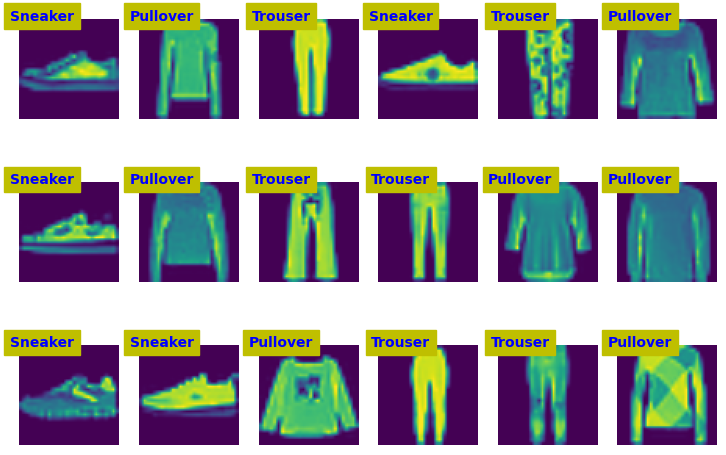

In [10]:
#view some images
X,y = next(iter(data_loader))

fig, axs = plt.subplots(3, 6, figsize=(9,6))

for i, ax in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  pic = pic/2 + 0.5

  label = dataset.classes[y[i]]
  ax.imshow(pic)
  ax.text(14,0, label, ha = 'center', fontweight = 'bold', color = 'blue', backgroundcolor = 'y')
  ax.axis('off')

plt.show()

Create classes for discriminator and generator

In [11]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    #convolutional layers
    self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias = False)
    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
    self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
    self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
    self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias = False)

    #batch norm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.bn2(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.bn3(x)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = self.bn4(x)
    x = F.sigmoid(self.conv5(x)).view(-1,1)
    return x

In [12]:
dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

In [13]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False)
    self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
    self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
    self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False)

    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(64)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = torch.tanh(self.conv5(x))
    return x

In [14]:
gnet = generatorNet()

torch.Size([10, 1, 64, 64])


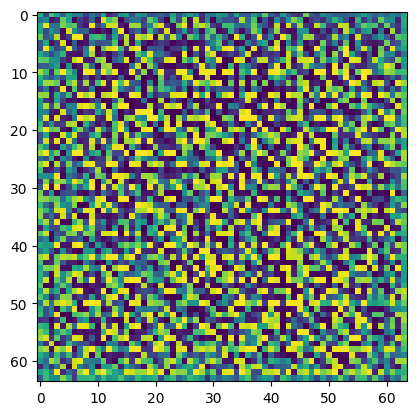

In [15]:
y = gnet(torch.randn(10, 100, 1, 1))
print(y.shape)
plt.imshow(y[0, :, :, :].squeeze().detach().numpy())
plt.show()

In [16]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [17]:
num_epochs = int(2500/len(data_loader))

In [18]:
num_epochs


losses = []
disDecs = []

for ep in range(num_epochs):
  for data, _ in data_loader:
    data = data.to(device)

    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)

    #Train the discriminator

    pred_real = dnet(data)
    d_loss_real = lossfun(pred_real, real_labels)

    fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
    fake_images = gnet(fake_data)
    pred_fake = dnet(fake_images)
    d_loss_fake = lossfun(pred_fake, fake_labels)

    d_loss = d_loss_fake + d_loss_real

    #backpropogation
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #Train the generator
    fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
    pred_fake = dnet(fake_images)
    g_loss = lossfun(pred_fake, real_labels)

    #backpropogation
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    losses.append((d_loss.item(), g_loss.item()))

    d1 = torch.mean((pred_real > 0.5).float()).detach()
    d2 = torch.mean((pred_fake > 0.5).float()).detach()
    disDecs.append((d1, d2))

  msg = f'Finished epoch {ep+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)

losses = np.array(losses)
disDecs = np.array([[float(d.cpu().numpy()) for d in dec] for dec in disDecs])

Finished epoch 13/13

In [19]:
def smooth(x, k = 15):
  return np.convolve(x,np.ones(k)/k, mode = 'same')

In [20]:
losses

array([[1.58254433, 2.44499326],
       [1.94471049, 2.95170331],
       [1.35179913, 4.68000269],
       ...,
       [0.03785167, 5.97503996],
       [0.03092991, 4.85717058],
       [0.03771652, 3.69477463]])

In [21]:
print(type(disDecs))
print(len(disDecs))
print(disDecs[:5])


<class 'numpy.ndarray'>
2340
[[0.22       0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.98999995 0.        ]]


In [22]:
print("disDecs shape:", np.shape(disDecs))

disDecs shape: (2340, 2)


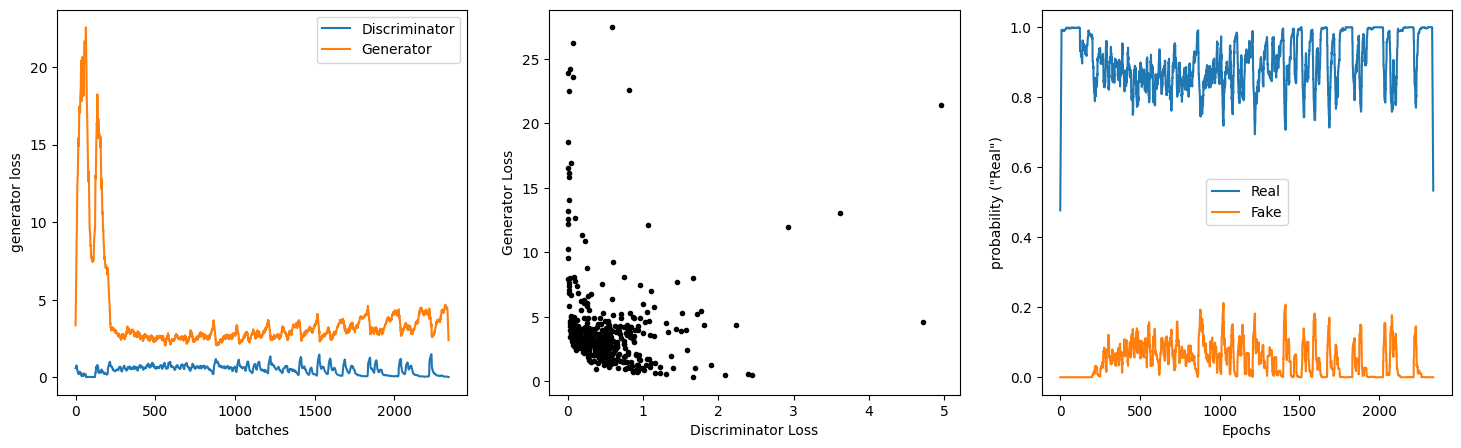

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5))

ax[0].plot(smooth(losses[:, 0]))
ax[0].plot(smooth(losses[:, 1]))
ax[0].set_xlabel('batches')
ax[0].set_ylabel('generator loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[::5, 0], losses[::5, 1], 'k.')
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(smooth(disDecs[:, 0]))
ax[2].plot(smooth(disDecs[:, 1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('probability ("Real")')
ax[2].legend(['Real', 'Fake'])

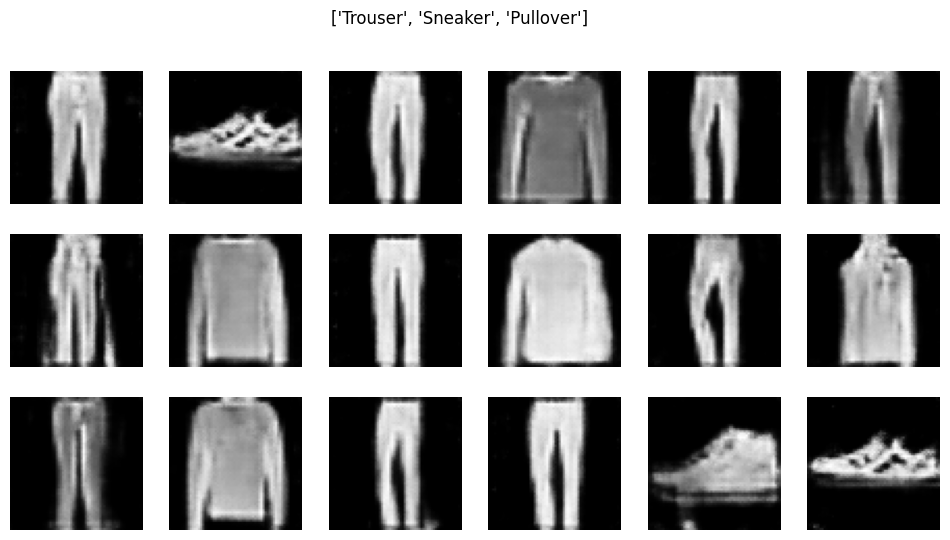

In [38]:
gnet.eval()
fake_data = gnet(torch.randn(batchsize, 100, 1, 1).to(device)).cpu()

fig, axs = plt.subplots(3, 6, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    img = fake_data[i, 0, :, :].detach().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle(classes_to_focus, y=0.98)
plt.show()
